# Application marketing

## Objectif :

Dans ce projet, nous tenterons de créer une combinaison de scores représentant la présence de dispositifs d'aide aux personnes à mobilité réduite dans les gares SNCF et d'une autre source de donnée les informations sur la population environnante.






Pour cela nous allons analyser ces données et les traiter de sorte à en extirper ce dont nous avons besoin.

## 1.1 Import des packages

L'uilisation de certains packages nous facilitent les traitement tel que sklearn, pandas et numpy seront nos outils d'extraction et de manipulation des données.
Nous aurons également besoin de packages pour les représentations graphiques.

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1.2 Les données

In [2]:
# SNCF
base_gares = pd.read_csv('sncf/base_gares.csv',sep = ';')
sncf_adresse = pd.read_csv('sncf/sncf-gares-et-arrets-transilien-ile-de-france.csv',sep = ';')
sncf_equipements = pd.read_csv('sncf/sncf-accessibilite-des-gares-equipements.csv',sep = ';').replace("Pas de CAB",0).fillna(0)
sncf_arret = pd.read_csv('sncf/lignes_points_arret.csv', sep = ';')

#INSEE
insee_pop = pd.read_csv('Insee/insee_pop_2011.csv', sep = ';', low_memory = False, encoding = 'iso8859-1')#, dtype = {'CODGEO': str }
effectifs_etablissements = pd.read_csv('Insee/effectifs_etablissements_com.csv', sep = ';', encoding = 'iso8859-1')

Séléction des colonnes pour les données SNCF :

In [3]:
BASES = base_gares.iloc[:,[0,1,3]]
ADRESSE = sncf_adresse.iloc[:,[0,7]]
EQUIPEMENT = sncf_equipements.iloc[:,[0]]
ARRET = sncf_arret.iloc[:,[0]]

Les derniéres colonnes de la table sncf_equipements ont différents ordres de grandeur, ce qui serait interessant de faire est de centrer et réduire nos données.
Sklearn nous permet de faire ça :

In [4]:
architecture = sncf_equipements.iloc[:,7:9]
scaler = StandardScaler()
scaler.fit(architecture)
architecture = scaler.transform(architecture)

On crée les indicateurs suivant en sommant leur répartition pour les différents champs choisis.

In [5]:
#Nombre d'équipement d'aide aux personnes à mobilité réduite :
EQUIPEMENT['Nb_equipemt'] = np.sum(sncf_equipements.iloc[:,2:6], axis =1)
#Dispositifs architecturaux de la gare :
EQUIPEMENT['Type_Achi'] = np.sum(architecture, axis =1)
#Nombre de lignes de transports par gare :
ARRET['Nb_Lignes'] = np.sum(sncf_arret.iloc[:,6:21], axis =1)
#Nombre de types de moyens de transport :
ARRET['Nb_Moy_Transp'] = np.sum(sncf_arret.iloc[:,2:5], axis =1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Même traitement pour les tables INSEE.

In [6]:
INSEEPOP = insee_pop.iloc[:,[0,6,7]]
INSEESAL = effectifs_etablissements.iloc[:,[0]].fillna(0)
#Nombre de salariés par commune :
INSEESAL['Salarie'] = np.sum(effectifs_etablissements.loc[:,'EFFECTIF_AZ':'EFFECTIF_OQ'].fillna(0), axis =1)
#Ratio du nombre de salariés sur l'effectif de la population en 2006 et en 2011 :
ratio_emp06 = INSEESAL['Salarie'] / INSEEPOP['P06_POP']
ratio_emp11 = INSEESAL['Salarie'] / INSEEPOP['P11_POP']

alpha = ratio_emp06/ratio_emp11
beta = alpha.sum() / len(alpha)
#On constate que nos indicateurs sont sensiblement égaux,
#nous obtenons un rapport des deux proche de 1.
#On choisira pour la suite la population de 2011.

## 1.3 Les jointures

On joint les tables SNCF et nos indicateurs.

In [8]:
JOIN1 = BASES.merge(ADRESSE, how='left',on='code_uic')
JOIN2 = JOIN1.merge(EQUIPEMENT, how='left',on='code_uic')
JOIN3 = JOIN2.merge(ARRET, how='left',on='code_uic')
JOIN3 = JOIN3.fillna(0)
JOIN3['code_insee_commune'] = JOIN3['code_insee_commune'].astype(str)
JOIN3.head()

,code_uic,Partitionner,nb_voy,code_insee_commune,Nb_equipemt,Type_Achi,Nb_Lignes,Nb_Moy_Transp
0,87001479,1-Apprentissage,4,93073,3.0,2.807353,1.0,1.0
1,87111278,2-Test,4,75117,3.0,3.658109,1.0,1.0
2,87113001,1-Apprentissage,5,75110,3.0,3.384720,1.0,1.0
3,87113209,1-Apprentissage,4,93055,3.0,-0.899646,1.0,1.0
4,87113217,1-Apprentissage,5,93053,4.0,4.204887,1.0,2.0


Création de la table finale INSEE.

In [9]:
INSEE =  INSEEPOP.merge(INSEESAL, how='right',left_on='CODGEO', right_on='COM')
INSEE['ratio_emp']=ratio_emp11
INSEE = INSEE.drop(['P06_POP','COM'], axis = 1)
INSEE = INSEE.rename(columns={'CODGEO':'code_insee_commune'})

Jointure finale :

In [10]:
TOTAL = JOIN3.merge(INSEE, how = 'left',on='code_insee_commune')
TOTAL.head(6)

,code_uic,Partitionner,nb_voy,code_insee_commune,Nb_equipemt,Type_Achi,Nb_Lignes,Nb_Moy_Transp,P11_POP,Salarie,ratio_emp
0,87001479,1-Apprentissage,4,93073,3.0,2.807353,1.0,1.0,34452.0,40120,2.219640
1,87111278,2-Test,4,75117,3.0,3.658109,1.0,1.0,170174.0,92994,0.546464
2,87113001,1-Apprentissage,5,75110,3.0,3.384720,1.0,1.0,94027.0,73293,0.779489
3,87113209,1-Apprentissage,4,93055,3.0,-0.899646,1.0,1.0,53797.0,26302,1.168718
4,87113217,1-Apprentissage,5,93053,4.0,4.204887,1.0,2.0,40232.0,9428,1.339775
5,87113407,1-Apprentissage,5,93010,3.0,5.359619,2.0,2.0,53051.0,12048,1.398978


Traitement et vérification de nos données.

In [11]:
TOTAL.code_uic= TOTAL['code_uic'].astype('category')
data = TOTAL.drop(['code_insee_commune'], axis=1)
data.to_csv("fichier_sncf_pmr.csv", index=False)
data.isnull().sum()

code_uic         0
Partitionner     0
nb_voy           0
Nb_equipemt      0
Type_Achi        0
Nb_Lignes        0
Nb_Moy_Transp    0
P11_POP          0
Salarie          0
ratio_emp        0
dtype: int64

In [12]:
train = data[data['Partitionner'] == '1-Apprentissage']
Y_train = train.nb_voy
X_train = train.drop(['nb_voy','Partitionner','code_uic'], axis=1)
 
test = data[data['Partitionner'] == '2-Test']
Y_test = test.nb_voy
X_test = test.drop(['nb_voy','Partitionner','code_uic'], axis=1)

## 2.2 Ramdom Forest

Initialisation de nos paramètres et sélectionde la méthode de régression :

In [13]:
forest = RandomForestClassifier(n_estimators=500,criterion="gini", max_depth=2,min_samples_split=2, min_samples_leaf=1,max_features="auto", max_leaf_nodes=None,bootstrap=True, oob_score=True)

forest.fit(X_train, Y_train)

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [2,3,4,5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, Y_train)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  3.1min finished


Fiabilité de notre score en moyenne : 0.5523809523809524
Nous obtenons un score plutôt moyen, cela indique que nos indicateurs expliquent partiellement nos données


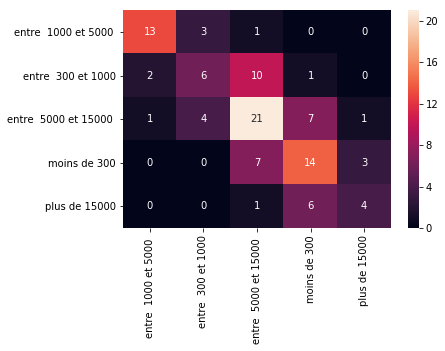

In [14]:
predicted = bestF.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
print(f'Fiabilité de notre score en moyenne : {accuracy}')

matrice = pd.DataFrame(confusion_matrix(Y_test, predicted),columns=['entre  1000 et 5000 ','entre  300 et 1000','entre  5000 et 15000 ','moins de 300','plus de 15000'],index=['entre  1000 et 5000 ','entre  300 et 1000','entre  5000 et 15000 ','moins de 300','plus de 15000'])
sns.heatmap(matrice, annot=True)

print('Nous obtenons un score plutôt moyen, cela indique que nos indicateurs expliquent partiellement nos données')

Vérification de nos données :

In [19]:
print('Comptage des valeurs pour nos données')
print('_____________________________________________________________________________________')
print('Y_train :')
print(Y_train.value_counts())
print('_____________________________________________________________________________________')
print('Y_test :')
print(Y_test.value_counts())
print('_____________________________________________________________________________________')
print('X_train :')
print(X_train.value_counts())
print('_____________________________________________________________________________________')
print('X_test :')
print(X_test.value_counts())
print('_____________________________________________________________________________________')

Comptage des valeurs pour nos données
_____________________________________________________________________________________
Y_train :
3    99
4    65
2    48
1    35
5    30
Name: nb_voy, dtype: int64
_____________________________________________________________________________________
Y_test :
3    34
4    24
2    19
1    17
5    11
Name: nb_voy, dtype: int64
_____________________________________________________________________________________
X_train :
Nb_equipemt  Type_Achi  Nb_Lignes  Nb_Moy_Transp  P11_POP  Salarie  ratio_emp
1.0          -0.899646  1.0        1.0            45010.0  19664    0.844383     3
4.0           2.229987  2.0        2.0            58341.0  34755    5.849041     2
1.0          -0.899646  1.0        1.0            11980.0  1300     1.957831     2
0.0          -0.899646  1.0        1.0            12909.0  2471     10.790393    2
1.0          -0.899646  1.0        1.0            28368.0  4531     0.177603     2
                                                

In [20]:
feature_imp = pd.Series(forest.feature_importances_, index= X_train.keys()).sort_values(ascending= False)
feature_imp

P11_POP          0.261246
Type_Achi        0.226807
Nb_equipemt      0.220239
Salarie          0.208911
ratio_emp        0.047906
Nb_Lignes        0.027688
Nb_Moy_Transp    0.007203
dtype: float64

In [21]:
feature_imp.sum()

1.0000000000000002

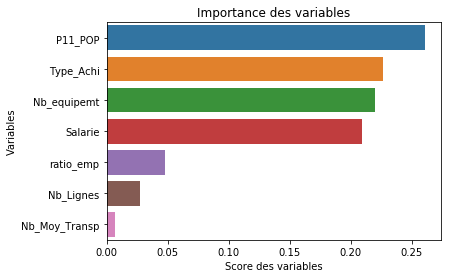

In [22]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score des variables')
plt.ylabel('Variables')
plt.title("Importance des variables")

plt.show()

In [25]:
print('Indicateurs de notre méthode :')
print('_________________________________________________________________')
print('Matrice de confusion :')
print(confusion_matrix(Y_test,predicted))
print('_________________________________________________________________')
print('Rapport de classifications :')
print(classification_report(Y_test,predicted))
print('_________________________________________________________________')
print('Précision /1:')
print(accuracy_score(Y_test,predicted))
print('_________________________________________________________________')

Indicateurs de notre méthode :
_________________________________________________________________
Matrice de confusion :
[[13  3  1  0  0]
 [ 2  6 10  1  0]
 [ 1  4 21  7  1]
 [ 0  0  7 14  3]
 [ 0  0  1  6  4]]
_________________________________________________________________
Rapport de classifications :
             precision    recall  f1-score   support

          1       0.81      0.76      0.79        17
          2       0.46      0.32      0.37        19
          3       0.53      0.62      0.57        34
          4       0.50      0.58      0.54        24
          5       0.50      0.36      0.42        11

avg / total       0.55      0.55      0.55       105

_________________________________________________________________
Précision /1:
0.5523809523809524
_________________________________________________________________
